<span style="font-size:10pt">Copyright Jean-Luc CHARLES $-$ 2025/03/14 $-$ CC BY-SA 4.0 $-$  <img src="img/CC-BY-SA.jpeg" width="50"></span> 

# Training Reproducibility with tensorflow

<div class="alert alert-block alert-danger">
<span style="color:brown;font-family:arial;font-size:normal"> 
    It is fundamental to use a <span style="font-weight:bold;">Python Virtual Environment</span> (PVE) for each important Python project: the PVE makes it possible to control for each project the versions of the Python interpreter and "sensitive" modules (like tensorflow for example).</span></div>

This notebook should be run with tensorflow 2.16.2

## 1 - Import the required Python modules

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #suppress the numerous TensorFlow warnings

import tensorflow as tf
from tensorflow import keras

import sys
import matplotlib.pyplot as plt
import numpy as np
import cv2
from time import time

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# specific modules:
from utils.tools import scan_dir, plot_images, plot_loss_accuracy, elapsed_time_since, show_conf_matrix, plot_proportion_bar

print(f"Python    : {sys.version.split()[0]}")
print(f"tensorflow: {tf.__version__} with keras {keras.__version__}")
print(f"numpy     : {np.__version__}")
print(f"OpenCV    : {cv2.__version__}")

Python    : 3.12.3
tensorflow: 2.16.2 with keras 3.8.0
numpy     : 1.26.4
OpenCV    : 4.11.0


In [2]:
# allows to visualize the graphs directly in the cell of the notebook:
%matplotlib inline

Unless explicitly stated, we use this seed value to make reproducible the random generators:

In [3]:
SEED = 1234

## 2 - Reproducibility of pseudo-random generators <a name="2"></a>

The weights of a neural network are initialized by __random values__ : when pseudo-random generators are invoked several times in succession, different random sequence are created at each invocation. For example with `numpy.random.rand`:

In [4]:
import numpy as np
for _ in range(5):
    print(np.random.rand(6))

[0.45603827 0.70821322 0.35252659 0.29563773 0.62407757 0.48542822]
[0.9568662  0.54810641 0.12439047 0.91257303 0.58947437 0.25900053]
[0.38411879 0.68836348 0.66168493 0.3979489  0.59540401 0.82984824]
[0.26860359 0.82720484 0.64838725 0.65624545 0.62351925 0.551012  ]
[0.15125172 0.21329416 0.46380384 0.25356387 0.70061849 0.66928815]


<span style="color:brown">This behavior can be very inappropriate when studying the performance of a trained network as a function of meta-parameters:<br>every time you run the training of the neural network (runing the cell or the notebook) with different values of the meta-parameters, you get a different initial state of the network, leading to a different training network...
</spawn>

### The seed of random generators

The technical solution to get a reproducible random sequence from a (pseudo) random generator is to set the __seed__ of the generator.<br>

The following cells illustrate the mechanism:

In [5]:
for _ in range(5):
    np.random.seed(1234)
    print(np.random.rand(5))

[0.19151945 0.62210877 0.43772774 0.78535858 0.77997581]
[0.19151945 0.62210877 0.43772774 0.78535858 0.77997581]
[0.19151945 0.62210877 0.43772774 0.78535858 0.77997581]
[0.19151945 0.62210877 0.43772774 0.78535858 0.77997581]
[0.19151945 0.62210877 0.43772774 0.78535858 0.77997581]


<span style="color:brown">Setting the __seed__ ensure that the random sequence is the same even on other computers (Windows, Mac, Linux...).<br>
    The figure bellow comes from a Windows10 machine :
</spawn>
![img/seed_1234_w10.png](img/seed_1234_w10.png)

Of course if you change the seed you get a different random sequence:

In [6]:
for _ in range(5):
    np.random.seed(2345)
    print(np.random.rand(5))

[0.66064431 0.41360065 0.66810256 0.22994342 0.80767834]
[0.66064431 0.41360065 0.66810256 0.22994342 0.80767834]
[0.66064431 0.41360065 0.66810256 0.22994342 0.80767834]
[0.66064431 0.41360065 0.66810256 0.22994342 0.80767834]
[0.66064431 0.41360065 0.66810256 0.22994342 0.80767834]


## 3 - Load the MNIST dataset (images and labels)

We use the keras `load_data` function to load the data from the MNIST 
(see [tf.keras.datasets.mnist.load_data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data)):<br>
- `im_train`, `lab_train` are the training images and labels,
- `im_valid`, `lab_valid` are the validation images and labels.

In [7]:
(im_train, lab_train), (im_valid, lab_valid) = keras.datasets.mnist.load_data()

Let's check the `shape` and `dtype` attributes of the numpy arrays:

In [8]:
print(f"im_train.shape:  {im_train.shape}, dtype: {im_train.dtype}")
print(f"im_valid.shape:  {im_valid.shape}, dtype: {im_valid.dtype}")
print(f"lab_train.shape: {lab_train.shape}, dtype: {lab_train.dtype}")
print(f"lab_vaild.shape: {lab_valid.shape}, dtype: {lab_valid.dtype}")

im_train.shape:  (60000, 28, 28), dtype: uint8
im_valid.shape:  (10000, 28, 28), dtype: uint8
lab_train.shape: (60000,), dtype: uint8
lab_vaild.shape: (10000,), dtype: uint8


### Visualization of images and labels:

The local module `utils.tools` defines the `plot_images` function which can be used to diplay a grid of MINIT images.<br>
Let's plot a grid of images 4 x 6 geginning with the 600th image:

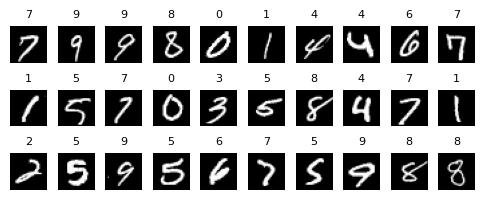

In [9]:
plot_images(im_train, 3, 10, 599, label_array=lab_train)

### Create the 3 datasets: train, validation & test

To follow the _state of the art_, we will split the whole dataset into train, validation & test datasets.<br>
A simple way to do this is to keep the train dataset and to split of the current validation dataset in two equal subsets:
- a new smaller validation set,
- a new test set.

In [10]:
# note on train_test_split : Stratified train/test split is not implemented for shuffle=False 

im_valid, im_test, lab_valid, lab_test = train_test_split(im_valid, lab_valid,
                                                          stratify=lab_valid,
                                                          test_size=0.5,
                                                          shuffle=True,
                                                          random_state=SEED)

Let's check the sizes of the 3 datasets:

In [11]:
print(f'train:  {im_train.shape}')
print(f'valid:  {im_valid.shape}')
print(f'test :  {im_test.shape}')

train:  (60000, 28, 28)
valid:  (5000, 28, 28)
test :  (5000, 28, 28)


We can verify that the proportion of digits remains homogenous in all the datasets:

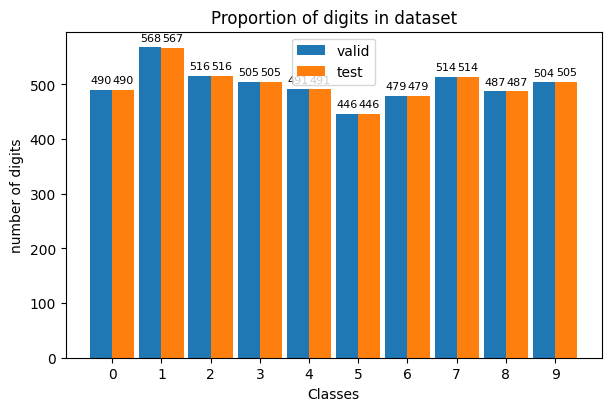

In [12]:
prop = {}
prop['valid'] = [ (lab_valid == i).sum() for i in range(10)]
prop['test']  = [ (lab_test  == i).sum() for i in range(10)]
plot_proportion_bar(prop, range(10))

### Setting useful parameters:

To avoid hard-coding the number of training, validation & test images as well as the size of the images, these numbers are recovered from the data set:
- with the shape attribute of the image arrays;
- with the size attribute of the first training image for example.

In [13]:
# number of training images:
NB_IM_TRAIN = im_train.shape[0]
NB_IM_VALID = im_valid.shape[0]     
NB_IM_TEST  = im_test.shape[0]     

# image shape:
IM_SHAPE = im_train[0].shape

# number of elements (pixels) of the firts training image: 
NB_PIXEL    = im_train[0].size   

# Visual checking:
print(f"Image size: {IM_SHAPE}={NB_PIXEL} pixels")

# number of classes:
NB_CLASS = len(set(lab_train))
print(f"{NB_CLASS} different classes found in the `lab_train` ndarray")

Image size: (28, 28)=784 pixels
10 different classes found in the `lab_train` ndarray


## 4 - Pre-process input dataset

Two treatments must be applied to the data from the MNIST database:
- on the images: transform the matrices of  28$\,\times\,$28 pixels (`uint8`integers) into **normalized** vectors $(V_i)_{i=0..783}$ of 784 real values $V_i$ with $ 0 \leqslant V_i \leqslant 1$;
- on labels: transform scalar numbers into *one-hot* vectors.

### Transform input matrices into normalized vectors

We define the arrays `x_train`, `x_valid` and `x_test` containing the matrices of the arrays `im_train`, `im_valid` and `im_test` *flattened* as normalized vectors (values between 0 and 1):

In [14]:
x_train = im_train.reshape(NB_IM_TRAIN, NB_PIXEL)/255
x_valid = im_valid.reshape(NB_IM_VALID, NB_PIXEL)/255
x_test  = im_test.reshape(NB_IM_TEST, NB_PIXEL)/255

#check:
print(f'train: {x_train.shape}, min: {x_train.min()}, max: {x_train.max()}')
print(f'valid: {x_valid.shape}, min: {x_valid.min()}, max: {x_valid.max()}')
print(f'test : {x_test.shape}, min: {x_test.min()}, max: {x_test.max()}')

train: (60000, 784), min: 0.0, max: 1.0
valid: (5000, 784), min: 0.0, max: 1.0
test : (5000, 784), min: 0.0, max: 1.0


### *one-hot* encoding of labels:

We use the **keras** `to_categorical` function to define the `y_train` and `y_valid` arrays containing the *hot-one* encoded version of `lab_train` and `lab_valid`:

In [15]:
from tensorflow.keras.utils import to_categorical
# 'one-hot' encoding' of labels :
y_train = to_categorical(lab_train)
y_valid = to_categorical(lab_valid)

Let's check the first 10 values of the `lab_train` and `y_train` arrays:

In [16]:
print(lab_train[:10])
print(y_train[:10])

[5 0 4 1 9 2 1 3 1 4]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


## 5 - Build the Dense Neural Network (DNN)

 To get short computation times we build a simple dense network to classify the MNIST images. Of course, this is not the "state of the art" : convolutive NN, transformers have much more impressive scores, but we just want want short training computation time.<br><br>
We buildthis naive **dense network**:
- an **input layer** of 784 values (the pixels of the MNIST 28 $\times$ 28 images put in the form of a vector of 784 normalized `float` numbers),
- a **hidden layer** of 784 neurons using the `relu` activation function,
- an **output layer** of 10 neurons, for the classification of the 10 digits {0,1,2...9}, using the `softmax` activation function adapted to classification problems .

<p style="text-align:center; font-style:italic; font-size:12px;">
      <img src="img/Simple-DNN.png" alt="archiNetwork.png" style="width:900px;"><br>
     [image credit: JLC]

In [17]:
NB_INPUT  = NB_PIXEL
NB_NEURON = NB_PIXEL

For the sake of convenience we défine a function to build the NN: 

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

def build_DNN(seed=None):

    if seed is not None:
        ##########################
        # Deterministic training #
        ##########################
        # 1/ set the seed of the random generators involved by tensorflow:
        tf.keras.utils.set_random_seed(seed)
        # 2/ make the tf ops determinisctic 
        # [see https://blog.tensorflow.org/2022/05/whats-new-in-tensorflow-29.html]
        tf.config.experimental.enable_op_determinism() 

    model = Sequential()
    model.add(Input(shape=(NB_INPUT,), name='input'))             # INPUT layer
    model.add(Dense(NB_NEURON, activation='relu', name='c1'))     # First hidden layer
    model.add(Dense(NB_CLASS, activation='softmax', name='c2'))   # OUTPUT layer
    model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])
    return model

Lets's look at the number of _parameters_ (the _weights_) of the model:

In [22]:
model = build_DNN()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ c1 (Dense)                      │ (None, 784)            │       615,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ c2 (Dense)                      │ (None, 10)             │         7,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 623,290 (2.38 MB)

 Trainable params: 623,290 (2.38 MB)

 Non-trainable params: 0 (0.00 B)

## 6 - Reproducibilty of the DNN training...

Perfect reproducibility of a neural network training may be difficult to achieve with tensorflow...<br>

To highlight the question of reproducibility we run a short experiment: run a loop where the model is built without setting the seed, trained and evaluated once (_epochs=1_) at each iteration:

#### A/ If we don't set the tensorflow seed, the training is not reproducible:

In the cell bellow, we train the network on only 1 epoch 5 times on a row:

In [25]:
for _ in range(5):
    model = build_DNN()  # Build a new model without setting seed
    hist = model.fit(x_train, y_train, epochs=1, batch_size=32, validation_data=(x_valid, y_valid), verbose=2)    

1875/1875 - 6s - 3ms/step - accuracy: 0.9444 - loss: 0.1875 - val_accuracy: 0.9700 - val_loss: 0.1005
1875/1875 - 6s - 3ms/step - accuracy: 0.9444 - loss: 0.1883 - val_accuracy: 0.9698 - val_loss: 0.1022
1875/1875 - 6s - 3ms/step - accuracy: 0.9439 - loss: 0.1909 - val_accuracy: 0.9672 - val_loss: 0.1170
1875/1875 - 6s - 3ms/step - accuracy: 0.9444 - loss: 0.1882 - val_accuracy: 0.9700 - val_loss: 0.1005
1875/1875 - 6s - 3ms/step - accuracy: 0.9423 - loss: 0.1927 - val_accuracy: 0.9702 - val_loss: 0.1003


In [44]:
for _ in range(5):
    model = build_DNN()  # Build a new model without setting seed
    hist = model.fit(x_train[:30000], y_train[:30000], epochs=1, batch_size=32, validation_data=(x_valid, y_valid), verbose=2)    

938/938 - 3s - 4ms/step - accuracy: 0.9232 - loss: 0.2583 - val_accuracy: 0.9632 - val_loss: 0.1206
938/938 - 3s - 4ms/step - accuracy: 0.9252 - loss: 0.2558 - val_accuracy: 0.9664 - val_loss: 0.1175
938/938 - 3s - 4ms/step - accuracy: 0.9253 - loss: 0.2564 - val_accuracy: 0.9654 - val_loss: 0.1210
938/938 - 3s - 4ms/step - accuracy: 0.9244 - loss: 0.2564 - val_accuracy: 0.9632 - val_loss: 0.1211
938/938 - 4s - 4ms/step - accuracy: 0.9235 - loss: 0.2561 - val_accuracy: 0.9636 - val_loss: 0.1218


In [28]:
for _ in range(5):
    model = build_DNN()  # Build a new model without setting seed
    hist = model.fit(x_train[:5000], y_train[:5000], epochs=1, batch_size=32, validation_data=(x_valid, y_valid), verbose=2)    

157/157 - 1s - 7ms/step - accuracy: 0.8536 - loss: 0.4900 - val_accuracy: 0.9088 - val_loss: 0.3040
157/157 - 1s - 7ms/step - accuracy: 0.8652 - loss: 0.4812 - val_accuracy: 0.8990 - val_loss: 0.3295
157/157 - 1s - 7ms/step - accuracy: 0.8544 - loss: 0.4842 - val_accuracy: 0.9090 - val_loss: 0.3018
157/157 - 1s - 7ms/step - accuracy: 0.8604 - loss: 0.4830 - val_accuracy: 0.9124 - val_loss: 0.3023
157/157 - 1s - 7ms/step - accuracy: 0.8528 - loss: 0.5011 - val_accuracy: 0.9064 - val_loss: 0.3021


In [42]:
for _ in range(5):
    model = build_DNN()  # Build a new model without setting seed
    hist = model.fit(x_train[:1000], y_train[:1000], epochs=1, batch_size=16, 
                     validation_data=(x_valid[:200], y_valid[:200]), verbose=2)    

63/63 - 1s - 12ms/step - accuracy: 0.7620 - loss: 0.8181 - val_accuracy: 0.8500 - val_loss: 0.5407
63/63 - 1s - 12ms/step - accuracy: 0.7670 - loss: 0.8276 - val_accuracy: 0.8600 - val_loss: 0.5338
63/63 - 1s - 12ms/step - accuracy: 0.7660 - loss: 0.8348 - val_accuracy: 0.8350 - val_loss: 0.5707
63/63 - 1s - 12ms/step - accuracy: 0.7580 - loss: 0.8314 - val_accuracy: 0.8600 - val_loss: 0.5397
63/63 - 1s - 12ms/step - accuracy: 0.7580 - loss: 0.8267 - val_accuracy: 0.8500 - val_loss: 0.5592


In [33]:
for _ in range(5):
    model = build_DNN()  # Build a new model without setting seed
    hist = model.fit(x_train[:1000], y_train[:1000], epochs=1, batch_size=32, validation_data=(x_valid[:200], y_valid[:200]), verbose=2)    

32/32 - 1s - 20ms/step - accuracy: 0.7180 - loss: 0.9928 - val_accuracy: 0.8200 - val_loss: 0.5567
32/32 - 1s - 19ms/step - accuracy: 0.7220 - loss: 0.9985 - val_accuracy: 0.7950 - val_loss: 0.6451
32/32 - 1s - 32ms/step - accuracy: 0.7060 - loss: 1.0562 - val_accuracy: 0.7850 - val_loss: 0.6342
32/32 - 1s - 19ms/step - accuracy: 0.7060 - loss: 1.0113 - val_accuracy: 0.8100 - val_loss: 0.6707
32/32 - 1s - 19ms/step - accuracy: 0.7310 - loss: 0.9619 - val_accuracy: 0.8450 - val_loss: 0.5673


In [29]:
for _ in range(5):
    model = build_DNN()  # Build a new model without setting seed
    hist = model.fit(x_train[:5000], y_train[:5000], epochs=1, batch_size=16, validation_data=(x_valid, y_valid), verbose=2)    

313/313 - 2s - 5ms/step - accuracy: 0.8738 - loss: 0.4526 - val_accuracy: 0.9096 - val_loss: 0.3045
313/313 - 2s - 5ms/step - accuracy: 0.8654 - loss: 0.4535 - val_accuracy: 0.8988 - val_loss: 0.3203
313/313 - 2s - 5ms/step - accuracy: 0.8584 - loss: 0.4627 - val_accuracy: 0.9032 - val_loss: 0.3199
313/313 - 2s - 5ms/step - accuracy: 0.8704 - loss: 0.4472 - val_accuracy: 0.9052 - val_loss: 0.3163
313/313 - 2s - 5ms/step - accuracy: 0.8626 - loss: 0.4573 - val_accuracy: 0.9206 - val_loss: 0.2695


In [23]:
for _ in range(5):
    model = build_DNN()  # Build a new model without setting seed
    hist = model.fit(x_train, y_train, epochs=1, batch_size=32, validation_data=(x_valid[:2000], y_valid[:2000]), verbose=2)    

1875/1875 - 6s - 3ms/step - accuracy: 0.9436 - loss: 0.1884 - val_accuracy: 0.9630 - val_loss: 0.1232
1875/1875 - 6s - 3ms/step - accuracy: 0.9435 - loss: 0.1892 - val_accuracy: 0.9675 - val_loss: 0.1109
1875/1875 - 6s - 3ms/step - accuracy: 0.9441 - loss: 0.1906 - val_accuracy: 0.9720 - val_loss: 0.1063
1875/1875 - 6s - 3ms/step - accuracy: 0.9443 - loss: 0.1897 - val_accuracy: 0.9655 - val_loss: 0.1167
1875/1875 - 6s - 3ms/step - accuracy: 0.9432 - loss: 0.1911 - val_accuracy: 0.9665 - val_loss: 0.1121


In [30]:
for _ in range(5):
    model = build_DNN()  # Build a new model without setting seed
    hist = model.fit(x_train, y_train, epochs=1, batch_size=16, validation_data=(x_valid[:2000], y_valid[:2000]), verbose=2)    

3750/3750 - 10s - 3ms/step - accuracy: 0.9456 - loss: 0.1799 - val_accuracy: 0.9695 - val_loss: 0.0986
3750/3750 - 10s - 3ms/step - accuracy: 0.9463 - loss: 0.1789 - val_accuracy: 0.9620 - val_loss: 0.1156
3750/3750 - 10s - 3ms/step - accuracy: 0.9450 - loss: 0.1805 - val_accuracy: 0.9645 - val_loss: 0.1216
3750/3750 - 10s - 3ms/step - accuracy: 0.9458 - loss: 0.1800 - val_accuracy: 0.9660 - val_loss: 0.1179
3750/3750 - 11s - 3ms/step - accuracy: 0.9459 - loss: 0.1797 - val_accuracy: 0.9720 - val_loss: 0.1012


In [31]:
for _ in range(5):
    model = build_DNN()  # Build a new model without setting seed
    hist = model.fit(x_train, y_train, epochs=1, batch_size=16, validation_data=(x_valid[:1000], y_valid[:1000]), verbose=2)    

3750/3750 - 10s - 3ms/step - accuracy: 0.9459 - loss: 0.1787 - val_accuracy: 0.9710 - val_loss: 0.0939
3750/3750 - 10s - 3ms/step - accuracy: 0.9448 - loss: 0.1807 - val_accuracy: 0.9730 - val_loss: 0.1100
3750/3750 - 10s - 3ms/step - accuracy: 0.9454 - loss: 0.1805 - val_accuracy: 0.9620 - val_loss: 0.1077
3750/3750 - 10s - 3ms/step - accuracy: 0.9460 - loss: 0.1799 - val_accuracy: 0.9740 - val_loss: 0.0864
3750/3750 - 10s - 3ms/step - accuracy: 0.9458 - loss: 0.1790 - val_accuracy: 0.9700 - val_loss: 0.0970


In [29]:
for _ in range(5):
    model = build_DNN()  # Build a new model without setting seed
    hist = model.fit(x_train, y_train, epochs=1, batch_size=16, validation_data=(x_valid, y_valid), verbose=2)    

3750/3750 - 10s - 3ms/step - accuracy: 0.9456 - loss: 0.1807 - val_accuracy: 0.9682 - val_loss: 0.0974
3750/3750 - 10s - 3ms/step - accuracy: 0.9445 - loss: 0.1810 - val_accuracy: 0.9664 - val_loss: 0.1069
3750/3750 - 10s - 3ms/step - accuracy: 0.9456 - loss: 0.1778 - val_accuracy: 0.9714 - val_loss: 0.0867
3750/3750 - 10s - 3ms/step - accuracy: 0.9459 - loss: 0.1812 - val_accuracy: 0.9718 - val_loss: 0.0915
3750/3750 - 10s - 3ms/step - accuracy: 0.9454 - loss: 0.1802 - val_accuracy: 0.9736 - val_loss: 0.0834


#### B/ If we just reload the network initial state, the training is not reproducible:

In [ ]:
model = build_DNN()
save_model_weights(model, 'DNN_relu_noseed_CPU.weights.h5')

In [35]:
for _ in range(5):
    model.load_weights('weights/DNN_relu_noseed_CPU.weights.h5') # reload the inital model weights
    hist = model.fit(x_train, y_train, epochs=1, batch_size=32, validation_data=(x_valid, y_valid), verbose=2)    

1875/1875 - 6s - 3ms/step - accuracy: 0.9747 - loss: 0.0801 - val_accuracy: 0.9796 - val_loss: 0.0670
1875/1875 - 5s - 3ms/step - accuracy: 0.9760 - loss: 0.0773 - val_accuracy: 0.9768 - val_loss: 0.0747
1875/1875 - 5s - 3ms/step - accuracy: 0.9761 - loss: 0.0783 - val_accuracy: 0.9760 - val_loss: 0.0873
1875/1875 - 5s - 3ms/step - accuracy: 0.9758 - loss: 0.0778 - val_accuracy: 0.9762 - val_loss: 0.0804
1875/1875 - 5s - 3ms/step - accuracy: 0.9759 - loss: 0.0787 - val_accuracy: 0.9788 - val_loss: 0.0747


In [36]:
model = build_DNN()
for _ in range(5):
    model.load_weights('weights/DNN_relu_noseed_CPU.weights.h5') # reload the inital model weights
    hist = model.fit(x_train, y_train, epochs=1, batch_size=16, validation_data=(x_valid, y_valid), verbose=2)    

3750/3750 - 11s - 3ms/step - accuracy: 0.9713 - loss: 0.0917 - val_accuracy: 0.9734 - val_loss: 0.0831
3750/3750 - 10s - 3ms/step - accuracy: 0.9710 - loss: 0.0934 - val_accuracy: 0.9670 - val_loss: 0.1059
3750/3750 - 10s - 3ms/step - accuracy: 0.9708 - loss: 0.0939 - val_accuracy: 0.9780 - val_loss: 0.0832
3750/3750 - 10s - 3ms/step - accuracy: 0.9713 - loss: 0.0927 - val_accuracy: 0.9766 - val_loss: 0.0749
3750/3750 - 10s - 3ms/step - accuracy: 0.9714 - loss: 0.0934 - val_accuracy: 0.9696 - val_loss: 0.0994


In [26]:
model = build_DNN()
for _ in range(5):
    model.load_weights('weights/DNN_relu_noseed_CPU.weights.h5') # reload the inital model weights
    hist = model.fit(x_train, y_train, epochs=1, batch_size=16, validation_data=(x_valid, y_valid), verbose=2)    

3750/3750 - 10s - 3ms/step - accuracy: 0.9716 - loss: 0.0924 - val_accuracy: 0.9740 - val_loss: 0.0900
3750/3750 - 10s - 3ms/step - accuracy: 0.9705 - loss: 0.0931 - val_accuracy: 0.9800 - val_loss: 0.0701
3750/3750 - 10s - 3ms/step - accuracy: 0.9708 - loss: 0.0936 - val_accuracy: 0.9758 - val_loss: 0.0788
3750/3750 - 10s - 3ms/step - accuracy: 0.9708 - loss: 0.0938 - val_accuracy: 0.9734 - val_loss: 0.0857
3750/3750 - 10s - 3ms/step - accuracy: 0.9712 - loss: 0.0945 - val_accuracy: 0.9772 - val_loss: 0.0788


In [31]:
model = build_DNN()
for _ in range(5):
    model.load_weights('weights/DNN_relu_noseed_CPU-2.weights.h5') # reload the inital model weights
    hist = model.fit(x_train, y_train, epochs=1, batch_size=32, validation_data=(x_valid, y_valid), verbose=2)    

1875/1875 - 6s - 3ms/step - accuracy: 0.9825 - loss: 0.0539 - val_accuracy: 0.9808 - val_loss: 0.0652
1875/1875 - 5s - 3ms/step - accuracy: 0.9845 - loss: 0.0494 - val_accuracy: 0.9772 - val_loss: 0.0750
1875/1875 - 5s - 3ms/step - accuracy: 0.9848 - loss: 0.0497 - val_accuracy: 0.9832 - val_loss: 0.0597
1875/1875 - 5s - 3ms/step - accuracy: 0.9846 - loss: 0.0488 - val_accuracy: 0.9776 - val_loss: 0.0776
1875/1875 - 6s - 3ms/step - accuracy: 0.9849 - loss: 0.0494 - val_accuracy: 0.9800 - val_loss: 0.0672


In [33]:
model = build_DNN()
for _ in range(5):
    model.load_weights('weights/DNN_relu_noseed_CPU-3.weights.h5') # reload the inital model weights
    hist = model.fit(x_train, y_train, epochs=1, batch_size=32, validation_data=(x_valid, y_valid), verbose=2)    

1875/1875 - 6s - 3ms/step - accuracy: 0.9435 - loss: 0.1907 - val_accuracy: 0.9700 - val_loss: 0.0989
1875/1875 - 5s - 3ms/step - accuracy: 0.9469 - loss: 0.1756 - val_accuracy: 0.9718 - val_loss: 0.0884
1875/1875 - 5s - 3ms/step - accuracy: 0.9463 - loss: 0.1748 - val_accuracy: 0.9762 - val_loss: 0.0841
1875/1875 - 5s - 3ms/step - accuracy: 0.9479 - loss: 0.1724 - val_accuracy: 0.9584 - val_loss: 0.1185
1875/1875 - 5s - 3ms/step - accuracy: 0.9475 - loss: 0.1745 - val_accuracy: 0.9718 - val_loss: 0.0897


#### C/ If the tensorflow seed is set for the network build, the training is reproducible:

In [34]:
for _ in range(5):
    model = build_DNN(seed=1)  # Build a new model with seed set
    hist = model.fit(x_train, y_train, epochs=1, batch_size=16, validation_data=(x_valid, y_valid), verbose=2)    

3750/3750 - 11s - 3ms/step - accuracy: 0.9469 - loss: 0.1782 - val_accuracy: 0.9698 - val_loss: 0.0983
3750/3750 - 10s - 3ms/step - accuracy: 0.9469 - loss: 0.1782 - val_accuracy: 0.9698 - val_loss: 0.0983
3750/3750 - 11s - 3ms/step - accuracy: 0.9469 - loss: 0.1782 - val_accuracy: 0.9698 - val_loss: 0.0983
3750/3750 - 10s - 3ms/step - accuracy: 0.9469 - loss: 0.1782 - val_accuracy: 0.9698 - val_loss: 0.0983
3750/3750 - 10s - 3ms/step - accuracy: 0.9469 - loss: 0.1782 - val_accuracy: 0.9698 - val_loss: 0.0983


#### D/ If we load the structure and the initial state f the network:

In [37]:
model = build_DNN(seed=1234)
model.save('models/DNN_seed1234_CPU.keras')

In [38]:
for _ in range(5):
    model = tf.keras.models.load_model('models/DNN_seed1234_CPU.keras') # reload the model structure & weights 
    hist = model.fit(x_train, y_train, epochs=1, batch_size=16, validation_data=(x_valid, y_valid), verbose=2)    

3750/3750 - 10s - 3ms/step - accuracy: 0.9457 - loss: 0.1790 - val_accuracy: 0.9688 - val_loss: 0.1067
3750/3750 - 10s - 3ms/step - accuracy: 0.9457 - loss: 0.1790 - val_accuracy: 0.9688 - val_loss: 0.1067
3750/3750 - 10s - 3ms/step - accuracy: 0.9457 - loss: 0.1790 - val_accuracy: 0.9688 - val_loss: 0.1067
3750/3750 - 10s - 3ms/step - accuracy: 0.9457 - loss: 0.1790 - val_accuracy: 0.9688 - val_loss: 0.1067
3750/3750 - 10s - 3ms/step - accuracy: 0.9457 - loss: 0.1790 - val_accuracy: 0.9688 - val_loss: 0.1067


$\leadsto$ the repoducibility is perfect &#128526; as for the case C/.

<span style="color:brown">We can ensure the reproducibility of the first epoch of the training:<br>
$\leadsto$ by setting the seed at the network creation (and everywhere else where required)<br>
$\leadsto$ or by reloading the entire network structure and state with the __tf.keras.models.load_model__ function<br><br>
If the creation of the network is costly, one can prefer to build it once, and then to reload the entire network structure and state and set the seed.   
</spawn>

### Running several identical trainings to compare their _Validation loss_ curves

Check some important parameters:

In [40]:
print(f'{x_train.shape=}')
print(f'{NB_INPUT=}, {NB_NEURON=}, {NB_CLASS=}')

x_train.shape=(60000, 784)
NB_INPUT=784, NB_NEURON=784, NB_CLASS=10


training  #1 #2 #3 #4 #5 Total Train Elapsed time 514s -> 00:08:34


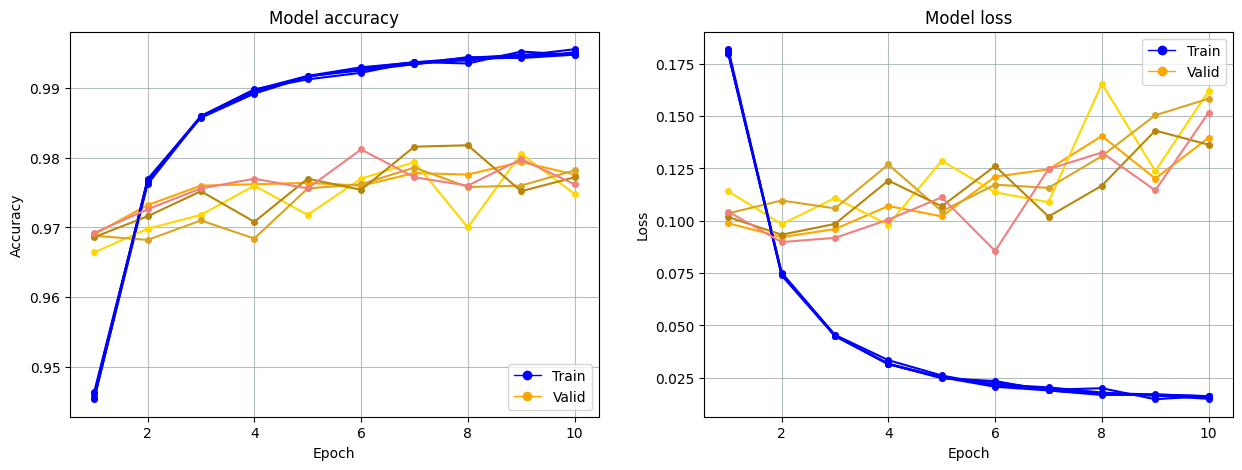

In [41]:
H, t0 = [], time()
print("training ", end="")

for i in range(5):
    print(f" #{i+1}", end="")
    
    # build a new network/
    model = build_DNN()
    
    hist = model.fit(x_train, y_train, # images, labels
                     epochs=10,        # the total number of successive trainings
                     batch_size=16,    # fragmentation of the whole dada set in batches
                     validation_data=(x_valid, y_valid), 
                     verbose=0)
    H.append(hist)  

print(f' Total Train {elapsed_time_since(t0)}')   
plot_loss_accuracy(H) 

training  #1 #2 #3 #4 #5 Total Train Elapsed time 280s -> 00:04:40


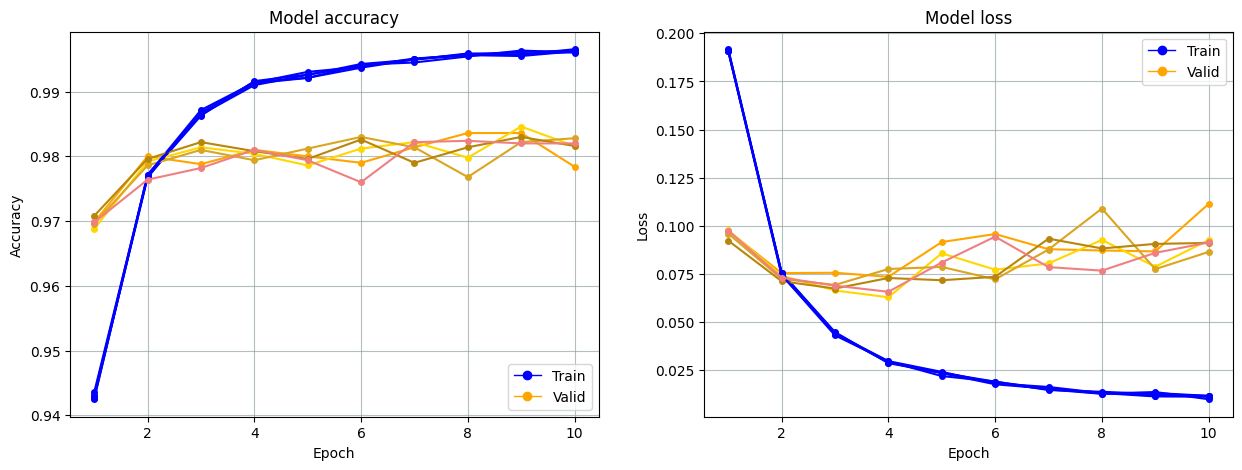

In [33]:
H, t0 = [], time()
print("training ", end="")

for i in range(5):
    print(f" #{i+1}", end="")
    
    # build a new network/
    model = build_DNN()
    
    hist = model.fit(x_train, y_train, # images, labels
                     epochs=10,        # the total number of successive trainings
                     batch_size=32,    # fragmentation of the whole dada set in batches
                     validation_data=(x_valid, y_valid), 
                     verbose=0)
    H.append(hist)  

print(f' Total Train {elapsed_time_since(t0)}')   
plot_loss_accuracy(H) 

training  #1 #2 #3 #4 #5 Total Train Elapsed time 171s -> 00:02:51


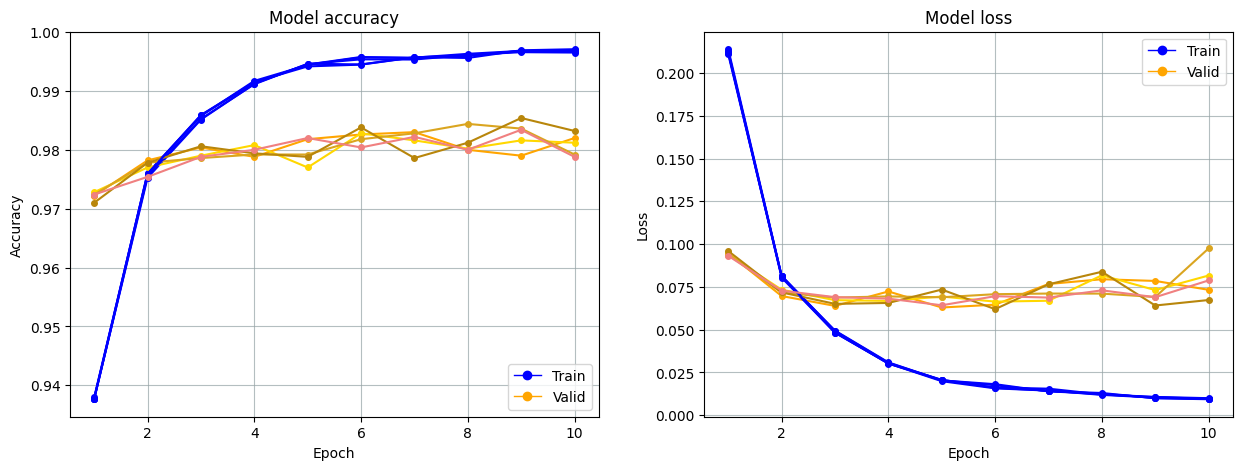

In [34]:
H, t0 = [], time()
print("training ", end="")

for i in range(5):
    print(f" #{i+1}", end="")
    
    # build a new network/
    model = build_DNN()
    
    hist = model.fit(x_train, y_train, # images, labels
                     epochs=10,        # the total number of successive trainings
                     batch_size=64,    # fragmentation of the whole dada set in batches
                     validation_data=(x_valid, y_valid), 
                     verbose=0)
    H.append(hist)  

print(f' Total Train {elapsed_time_since(t0)}')   
plot_loss_accuracy(H) 

training  #1 #2 #3 #4 #5 Total Train Elapsed time 113s -> 00:01:53


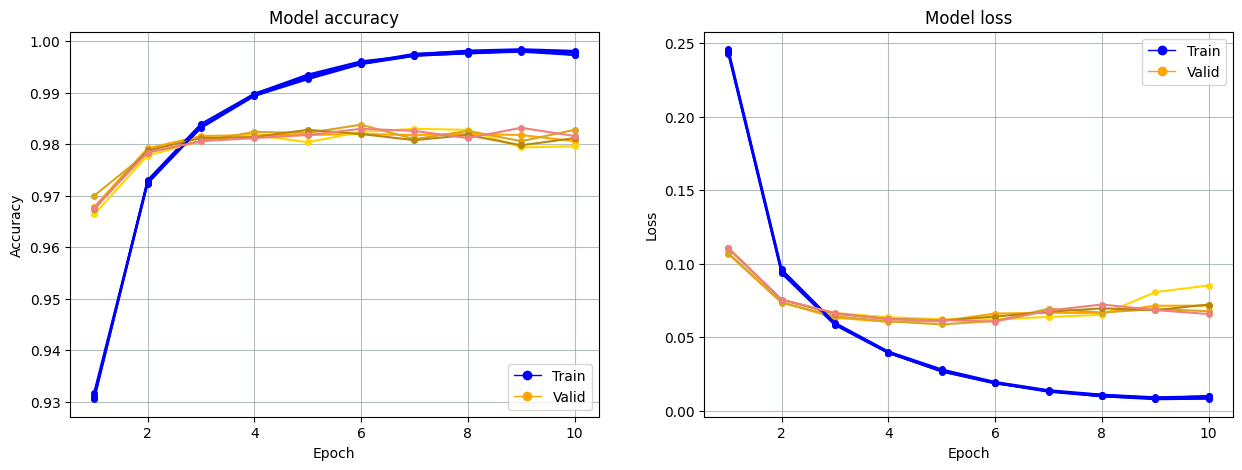

In [37]:
H, t0 = [], time()
print("training ", end="")

for i in range(5):
    print(f" #{i+1}", end="")
    
    # build a new network/
    model = build_DNN()
    
    hist = model.fit(x_train, y_train, # images, labels
                     epochs=10,        # the total number of successive trainings
                     batch_size=128,    # fragmentation of the whole dada set in batches
                     validation_data=(x_valid, y_valid), 
                     verbose=0)
    H.append(hist)  

print(f' Total Train {elapsed_time_since(t0)}')   
plot_loss_accuracy(H) 

training  #1 #2 #3 #4 #5 Total Train Elapsed time 109s -> 00:01:49


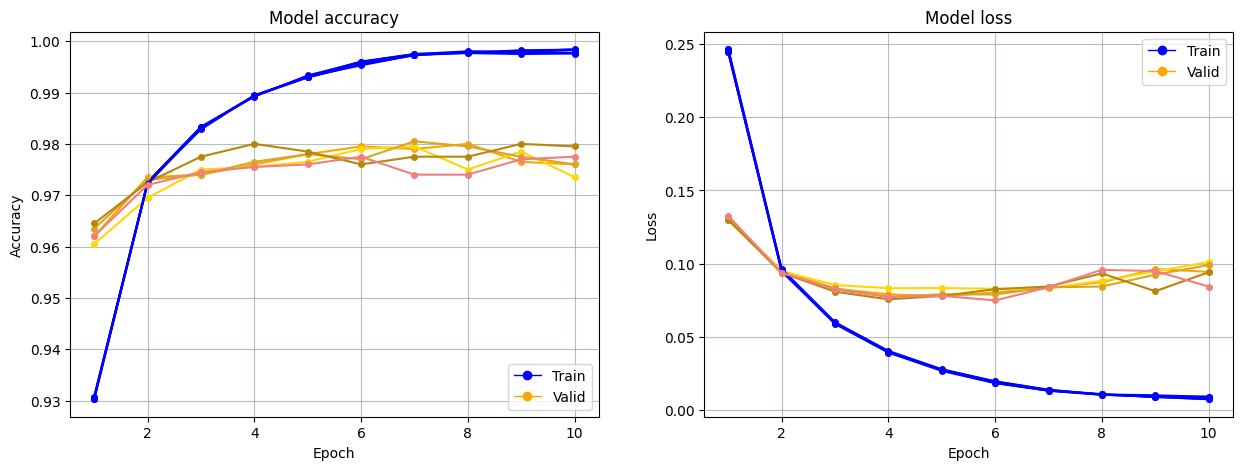

In [39]:
H, t0 = [], time()
print("training ", end="")

for i in range(5):
    print(f" #{i+1}", end="")
    
    # build a new network/
    model = build_DNN()
    
    hist = model.fit(x_train, y_train, # images, labels
                     epochs=10,        # the total number of successive trainings
                     batch_size=128,    # fragmentation of the whole dada set in batches
                     validation_data=(x_valid[:2000], y_valid[:2000]), 
                     verbose=0)
    H.append(hist)  

print(f' Total Train {elapsed_time_since(t0)}')   
plot_loss_accuracy(H) 

training  #1 #2 #3 #4 #5 Total Train Elapsed time 111s -> 00:01:51


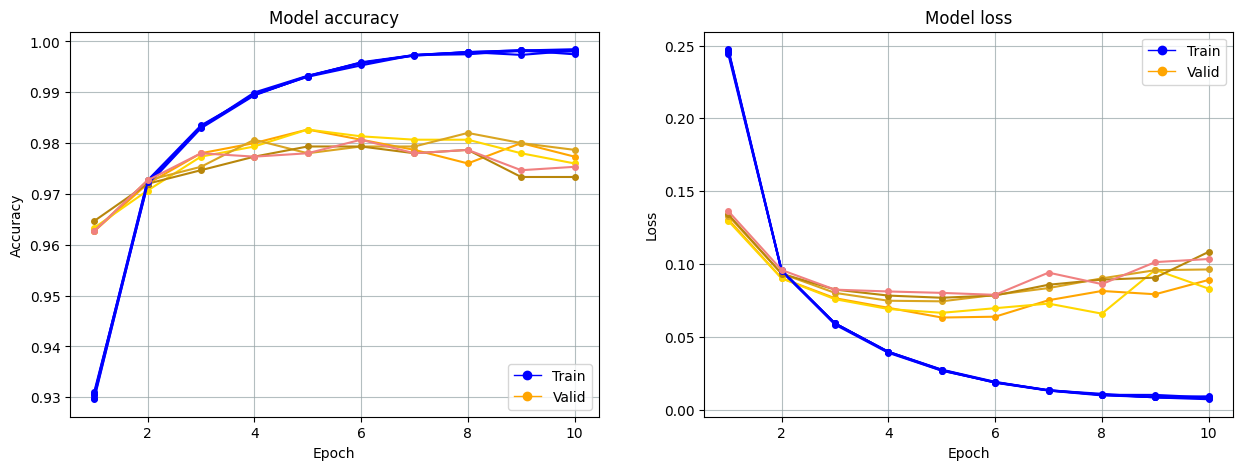

In [40]:
H, t0 = [], time()
print("training ", end="")

for i in range(5):
    print(f" #{i+1}", end="")
    
    # build a new network/
    model = build_DNN()
    
    hist = model.fit(x_train, y_train, # images, labels
                     epochs=10,        # the total number of successive trainings
                     batch_size=128,    # fragmentation of the whole dada set in batches
                     validation_data=(x_valid[:1500], y_valid[:1500]), 
                     verbose=0)
    H.append(hist)  

print(f' Total Train {elapsed_time_since(t0)}')   
plot_loss_accuracy(H) 

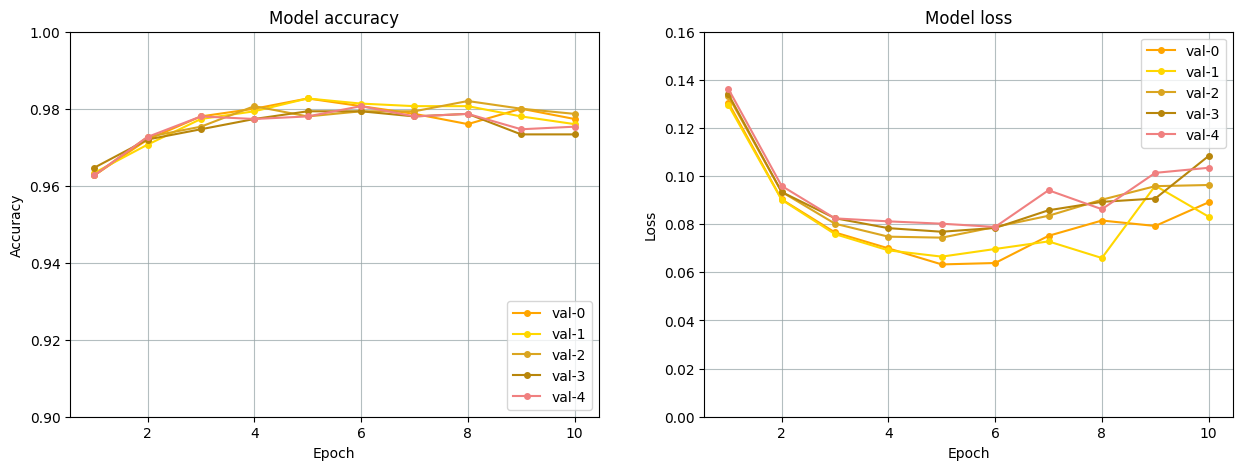

In [44]:
plot_loss_accuracy(H, training=False, single_legend=False, min_acc=0.9, max_acc=1, min_loss=.0, max_loss=.16)   

training  #1 #2 #3 #4 #5 Total Train Elapsed time 417s -> 00:06:57


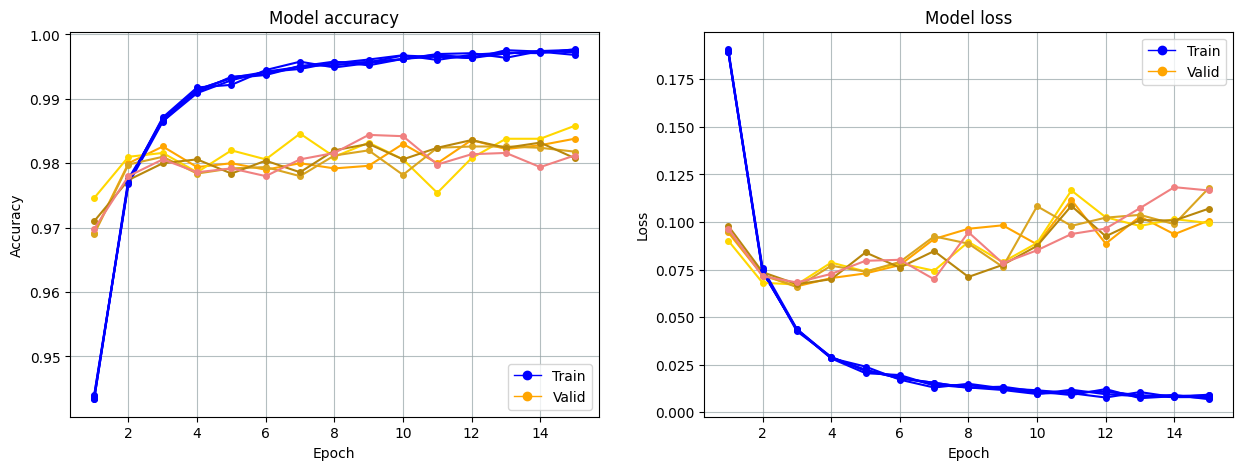

In [31]:
H, t0 = [], time()
print("training ", end="")

for i in range(5):
    print(f" #{i+1}", end="")
    
    # build a new network/
    model = build_DNN()
    
    hist = model.fit(x_train, y_train, # images, labels
                     epochs=15,        # the total number of successive trainings
                     batch_size=32,    # fragmentation of the whole dada set in batches
                     validation_data=(x_valid, y_valid), 
                     verbose=0)
    H.append(hist)  

print(f' Total Train {elapsed_time_since(t0)}')   
plot_loss_accuracy(H) 

training  #1 #2 #3 #4 #5 Total Train Elapsed time 254s -> 00:04:14


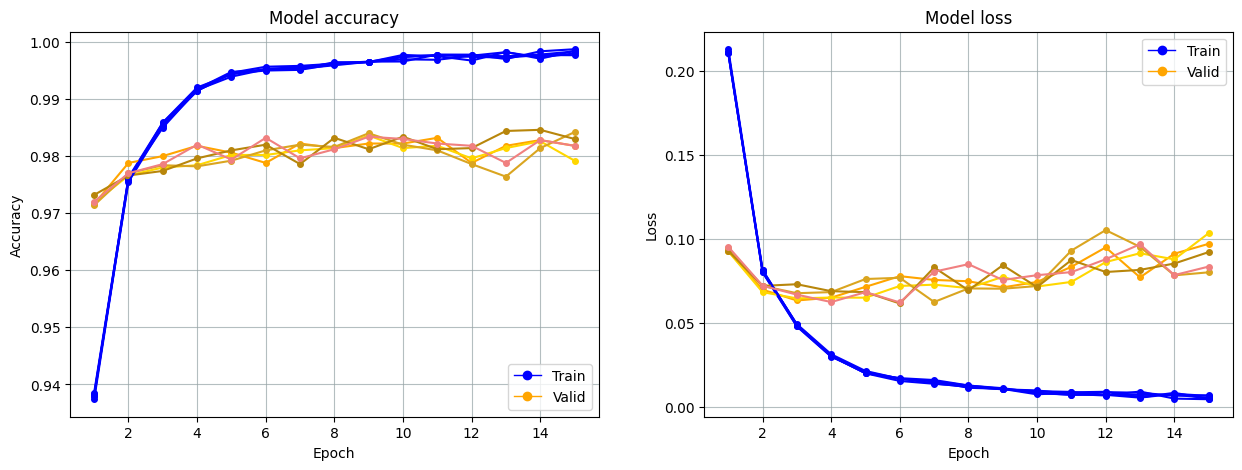

In [32]:
H, t0 = [], time()
print("training ", end="")

for i in range(5):
    print(f" #{i+1}", end="")
    
    # build a new network/
    model = build_DNN()
    
    hist = model.fit(x_train, y_train, # images, labels
                     epochs=15,        # the total number of successive trainings
                     batch_size=64,    # fragmentation of the whole dada set in batches
                     validation_data=(x_valid, y_valid), 
                     verbose=0)
    H.append(hist)  

print(f' Total Train {elapsed_time_since(t0)}')   
plot_loss_accuracy(H) 

training  #1 #2 #3 #4 #5 Total Train Elapsed time 165s -> 00:02:45


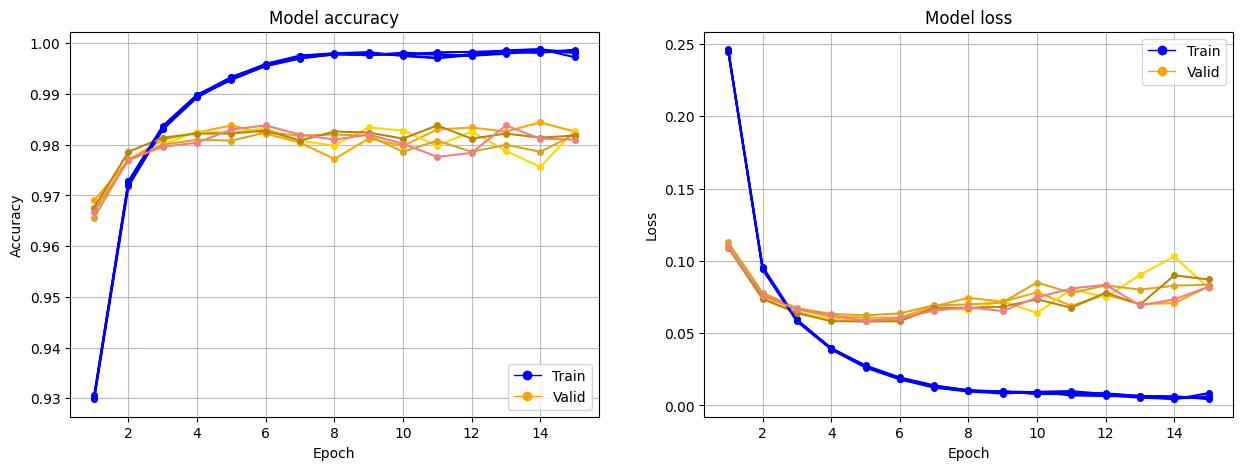

In [36]:
H, t0 = [], time()
print("training ", end="")

for i in range(5):
    print(f" #{i+1}", end="")
    
    # build a new network/
    model = build_DNN()
    
    hist = model.fit(x_train, y_train, # images, labels
                     epochs=15,        # the total number of successive trainings
                     batch_size=128,    # fragmentation of the whole dada set in batches
                     validation_data=(x_valid, y_valid), 
                     verbose=0)
    H.append(hist)  

print(f' Total Train {elapsed_time_since(t0)}')   
plot_loss_accuracy(H) 

The `val_loss` and `val_accuracy` differ at each training.<br>
It can be a problem if we use a _callback_ like __early stoppping__ : the training will stop at a different epoch if we run the training many times.

### Running several identical training with __reproducibility setting validated__

training  #1 #2 #3 #4 #5 Total Train Elapsed time 285s -> 00:04:45


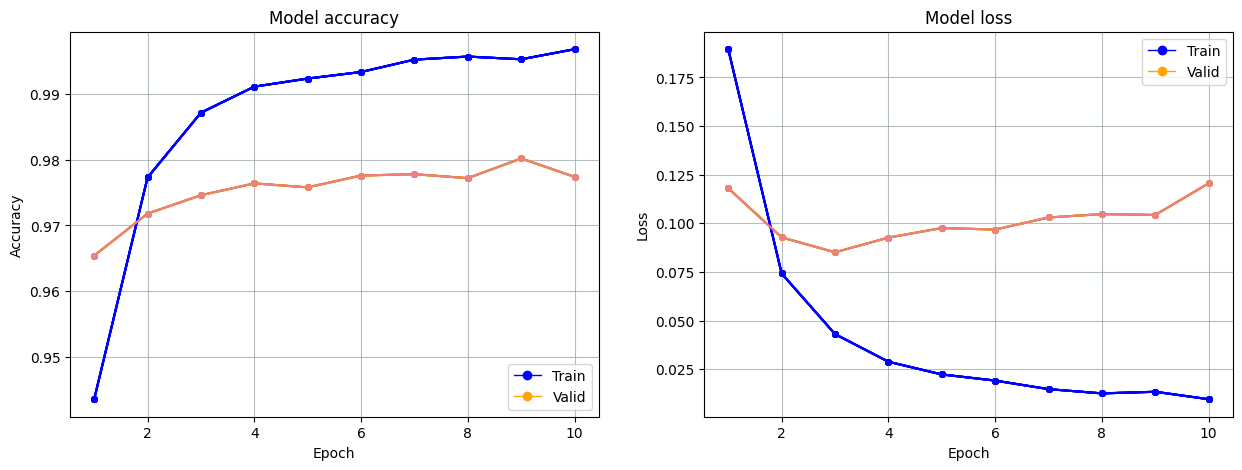

In [43]:
H, t0 = [], time()
print("training ", end="")

for i in range(5):
    print(f" #{i+1}", end="")
    
    # build a new network/
    model = build_DNN(1234)
    
    hist = model.fit(x_train, y_train, # images, labels
                     epochs=10,        # the total number of successive trainings
                     batch_size=32,    # fragmentation of the whole dada set in batches
                     validation_data=(x_valid, y_valid), 
                     verbose=0)
    H.append(hist)  

print(f' Total Train {elapsed_time_since(t0)}')   
plot_loss_accuracy(H) 

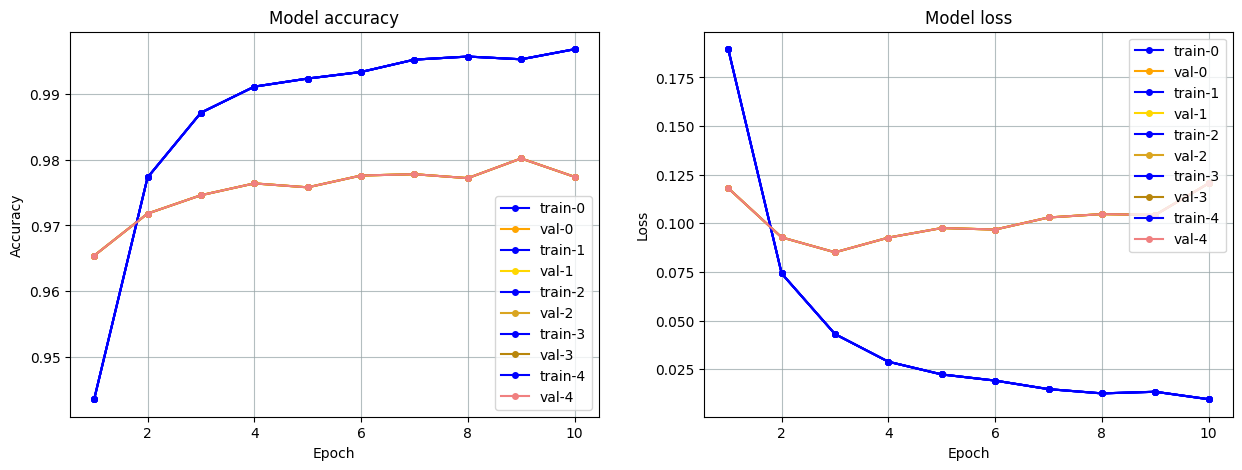

In [44]:
plot_loss_accuracy(H, single_legend=False)

training  #1 #2 #3 Total Train Elapsed time 157s -> 00:02:37


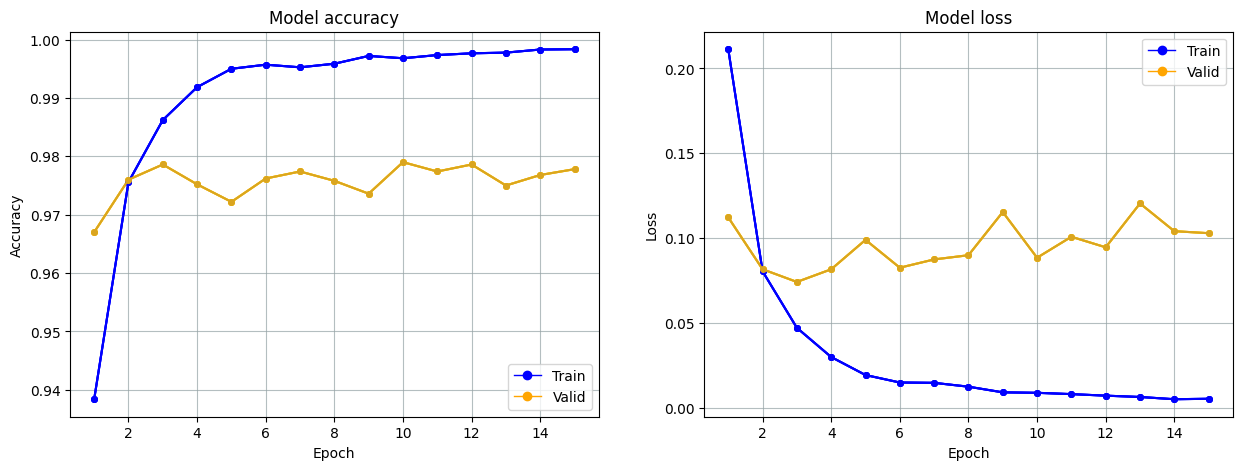

In [37]:
H, t0 = [], time()
print("training ", end="")

for i in range(3):
    print(f" #{i+1}", end="")
    
    # build a new network/
    model = build_DNN(1234)
    
    hist = model.fit(x_train, y_train, # images, labels
                     epochs=15,        # the total number of successive trainings
                     batch_size=16,    # fragmentation of the whole dada set in batches
                     validation_data=(x_valid, y_valid), 
                     verbose=0)
    H.append(hist)  

print(f' Total Train {elapsed_time_since(t0)}')   
plot_loss_accuracy(H) 

$\leadsto$ the repoducibility is perfect &#128526;

#### Reload the initial state and set the seed et each time:

training  #1

/home/jlc/work/IA-MachineLearning/16-Limoges-IRCEFR/Studies/Study-00/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


 #2 #3

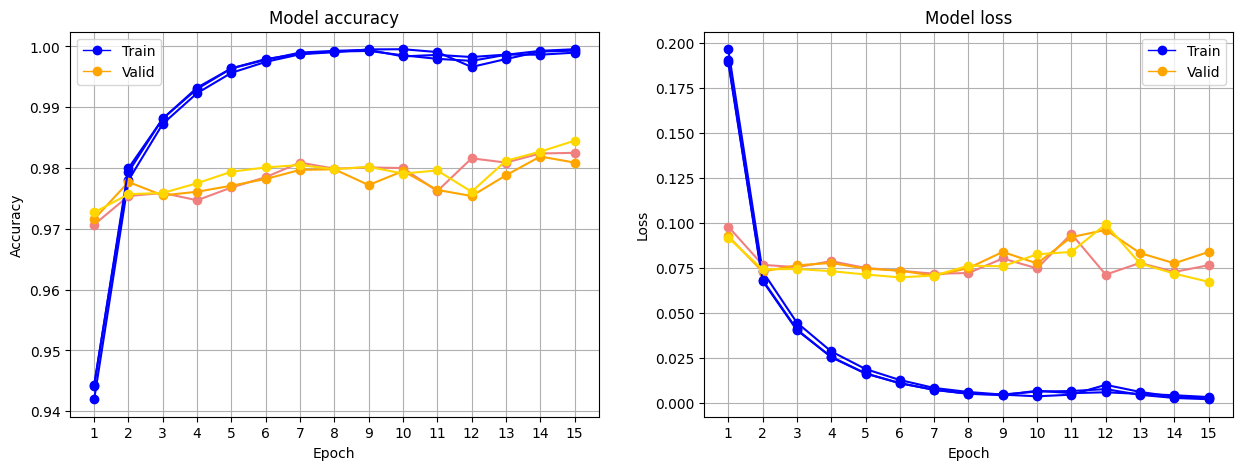

In [21]:
H, t0 = [], time()
print("training ", end="")

for i in range(3):
    print(f" #{i+1}", end="")
        
    # reload the structure of the NN and its initial state 
    model.load_weights('weights/initialNN.weights.h5') 
    
    # set the seed at each turn of the loop:
    tf.keras.utils.set_random_seed(1234)
    
    # train the network
    hist = model.fit(x_train, y_train, 
                     epochs=15, 
                     batch_size=128,
                     validation_data=(x_valid, y_valid), 
                     verbose=0)
    
    H.append(hist)  

print(f' Total Train {elapsed_time_since(t0)}')   
plot_loss_accuracy(H) 

training  #1 #2 #3

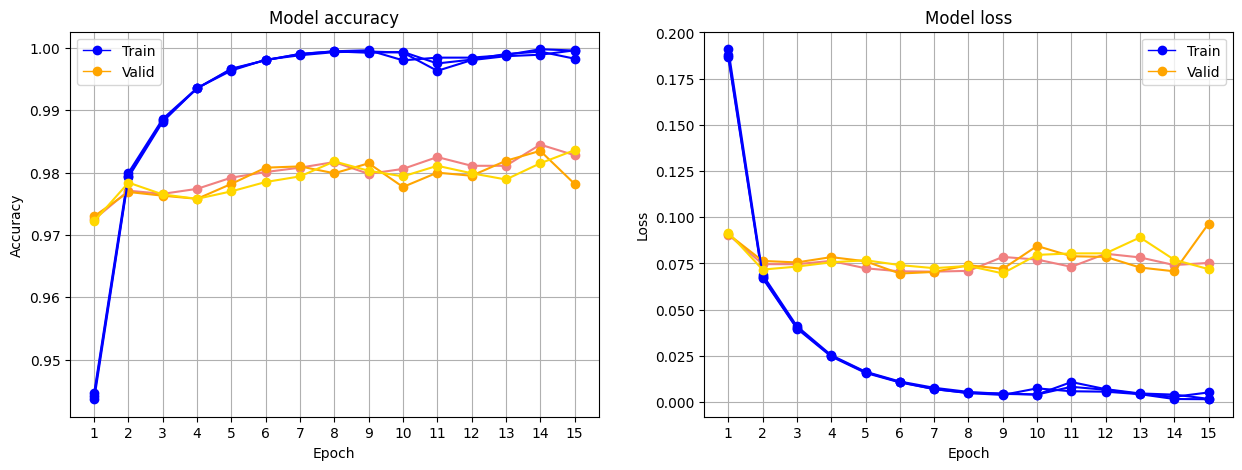

In [22]:
H, t0 = [], time()
print("training ", end="")

for i in range(3):
    print(f" #{i+1}", end="")
            
    # reload the structure of the NN and its initial state 
    model.load_weights('weights/initialNN.weights.h5') 
    
    # set the seed at each turn of the loop:
    tf.keras.utils.set_random_seed(1234)
    
    # train the network
    hist = model.fit(x_train, y_train, 
                     epochs=15, 
                     batch_size=128,
                     validation_data=(x_valid, y_valid), 
                     verbose=0)  
    H.append(hist)  

print(f' Total Train {elapsed_time_since(t0)}')   
plot_loss_accuracy(H) 

The `val_loss` and `val_accuracy` differ at each training.<br>
It can be a problem if we use a _callback_ like __early stoppping__ : the training will stop at a different epoch if we run the training many times.

#### Reload the entire structure and the initial state of the network and set the seed et each time:

training  #1 #2 #3

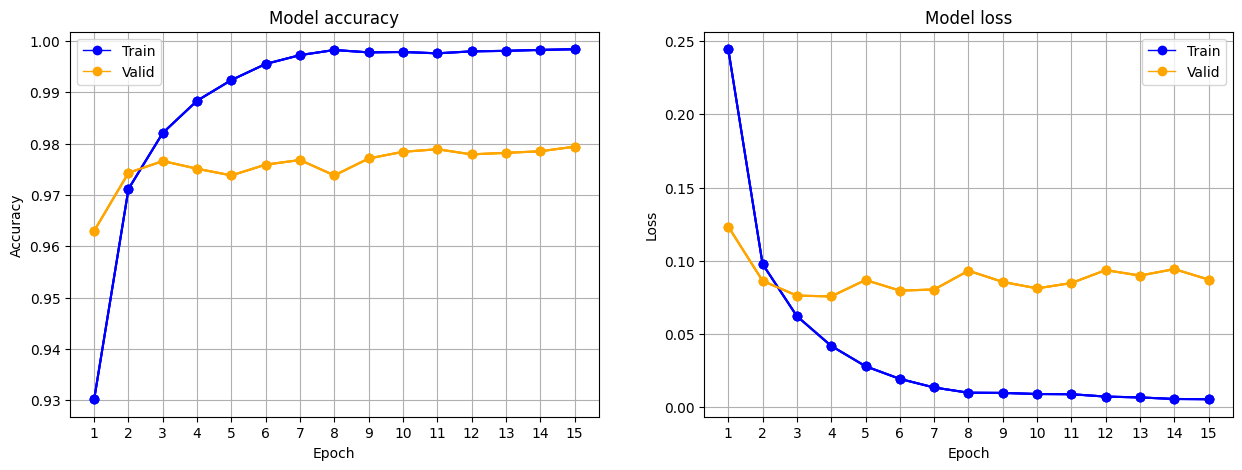

In [23]:
H, t0 = [], time()
print("training ", end="")

for i in range(3):
    print(f" #{i+1}", end="")
                
    # reload the structure of the NN and its initial state 
    model= tf.keras.models.load_model('models/initialNN.keras') 
    
    # set the seed at each turn of the loop:
    tf.random.set_seed(1234)
    
    # train the network
    hist = model.fit(x_train, y_train, 
                     epochs=15, 
                     batch_size=128,
                     validation_data=(x_valid, y_valid), 
                     verbose=0)
    H.append(hist)  

print(f' Total Train {elapsed_time_since(t0)}')   
plot_loss_accuracy(H) 

Now that the training is reproducible it makes sens to study the influnece of some meta-parameters (n_epoch, batch_size...) on the performance of the trained network.

# Other interesting resources... videos:

In [ ]:
%%HTML
<iframe src="https://www.youtube.com/embed/trWrEWfhTVg" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [ ]:
%%HTML
<iframe src="https://www.youtube.com/embed/aircAruvnKk" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [ ]:
%%HTML
<iframe src="https://www.youtube.com/embed/IHZwWFHWa-w" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [ ]:
%%HTML
<iframe src="https://www.youtube.com/embed/Ilg3gGewQ5U" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

### Saving the state of the NN

We can save the __initial random state__ of the weights of the untrained network with the `save_weights` method of the `Sequential` class:

In [59]:
import os

# check if the 'weights' directory exists, otherwise create it:
if not os.path.isdir("weights"): os.mkdir("weights")

#saving the initial values of the NN weights:
weights_file = 'initialNN.weights.h5'
model.save_weights('weights/' + weights_file)

# display the created files:
files=[os.path.join("weights",f) for f in os.listdir("weights")]
files.sort()
for f in files: print(f)

weights/initialNN.weights.h5


<h3 style="color:brown">Point of interest:</h3>

<span style="color:brown">
$\leadsto$ This can be useful to reset the network to its initial state before running new trainings
</spawn>

### Saving the full structure and the weights of the NN

The `save` method of the `Sequential` class allows to save in files **the full structure and the weights** of the NN:

In [60]:
import os

# check if the 'models' directory exists, otherwise create it:
if not os.path.isdir("models"): os.mkdir("models")

# saving the model structure & initial weights:
model_file = 'initialNN.keras'
model.save('models/' + model_file) 

# display the created files:
files=[os.path.join("models",f) for f in os.listdir("models")]
for f in files: print(f)

models/initialNN.keras


<h3 style="color:brown">Point of interest:</h3>

<span style="color:brown">We can re-create later from scratch the entire network (initial or trained state) with the __tf.keras.models.load_model__ function.
</spawn>